#Proyecto final : Predicción  del equipo ganador en un partido de la NBA

A continuación se presenta cada uno de los procedimientos que fueron necesarios para llevar acabo este problema de clasificación.

Estudiante a cargo del proyecto:


*   Nombre: David Andrés Torres Betancour
*   Cédula: 1017251689





#  Importación de Librerias

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from scipy.spatial import distance
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score,auc, plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KernelDensity
from itertools import product
from scipy import stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
warnings.filterwarnings('ignore')


# Lectura y limpieza de la base de datos

In [ ]:
def cleaningDataSet():

  url ='https://raw.githubusercontent.com/deivid-01/udea-simulacion-finalproyect/master/data/nbagames_stats.csv'

  #Setting dataframe
  df = pd.read_csv(url)

  #Deleting rows
  df = df.drop(columns = ['Unnamed: 0','Team','Date','Opponent','TeamPoints', 'OpponentPoints','FieldGoals', 
                        'FieldGoalsAttempted','X3PointShots','X3PointShotsAttempted','FreeThrows','FreeThrowsAttempted',
                        'Opp.FieldGoals', 'Opp.FieldGoalsAttempted','Opp.3PointShots', 'Opp.3PointShotsAttempted',
                        'Opp.FreeThrows', 'Opp.FreeThrowsAttempted',])

  #Renaming cols
  df=df.rename(columns={"WINorLOSS":"Win"})

  #Away=0 | Home=1
  df.Home[df.Home=='Away']=0
  df.Home[df.Home=='Home']=1
  #W=1 | L=0
  df.Win[df.Win=='L']=0
  df.Win[df.Win=='W']=1

  #Set target column at the end of dataframe
  df=df[[c for c in df if c not in ['Win',]] + ['Win']]
  #Converting column type
  df=df.astype({'Home':'int64','Win':'int64'})

  return df

def getXY(d):
  x =d.iloc[:,0:-1].values
  y= d.iloc[:,d.shape[1]-1].values
  return x,y

In [ ]:
df = cleaningDataSet()
x,y=getXY(df)

#Modelos de Predicción

### Parzen Window

In [ ]:
def testingParzen (X, Y, hs):
    
    skf = StratifiedKFold()
    resultados = pd.DataFrame()
    idx = 0

    for h in hs:

        accu_temp = []
       

        mean_fpr = np.linspace(0, 1, 100)

        for train, test in skf.split(X, Y):

            Xtrain = X[train,:]
            Ytrain = Y[train]
            Xtest = X[test,:]
            Ytest = Y[test]

            scaler = StandardScaler()
            scaler.fit(Xtrain)
            Xtrain = scaler.transform(Xtrain)
            Xtest = scaler.transform(Xtest)

            fds_matrix = np.zeros((Xtest.shape[0], 2))
            
            estimators = []
            for c in [0,1]:
              m = KernelDensity(bandwidth=h).fit(Xtrain[Ytrain==c])
              estimators.append(m)
            i = 0

            for estimator in estimators:
              
              fds_matrix[:,i]=estimator.score_samples(Xtest)
              
              i=i+1
            
           
            Yest=np.argmax(fds_matrix,1)

            
            accu_temp.append(accuracy_score(y_true=Ytest,y_pred=Yest))
        resultados.loc[idx,'Bandwidth '] = h 
        resultados.loc[idx,'Accuracy Test'] = np.mean(accu_temp)
        resultados.loc[idx,'Std'] = np.std(accu_temp)
        idx+=1
    return (resultados)

###Gradient Boosting Tree

In [ ]:
def testingGbt(num_trees, X, Y):

    #-------plot chance line
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
    #------------------------------------
    
    skf = StratifiedKFold()
    resultados = pd.DataFrame()

    
    idx = 0
    for trees in num_trees:
        
        AccuTrain = []
        AccuVal = []
        tprs = []

        
        mean_fpr = np.linspace(0, 1, 100)

        i = 1
        for train, test in skf.split(X, Y):
            Xtrain = X[train,:]
            Ytrain = Y[train]
            Xtest = X[test,:]
            Ytest = Y[test]

            modelo= GradientBoostingClassifier(n_estimators= trees)
            modelo =modelo.fit(Xtrain,Ytrain)
            
            Ytrain_pred =  modelo.predict(Xtrain)
            
            Yest = modelo.predict(Xtest)
            
            
            #plot roc curve -----------------------------
            viz = plot_roc_curve(modelo, Xtrain, Ytrain,
                         label="", alpha=0.0,ax=ax)
            
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            #---------------------------------------------
            i=i+1


            AccuTrain.append(accuracy_score(y_true=Ytrain,y_pred=Ytrain_pred))
            AccuVal.append(accuracy_score(y_true=Ytest,y_pred=Yest))

        resultados.loc[idx,'# Trees'] = trees
        resultados.loc[idx,'Accuracy Train'] = np.mean(AccuTrain)
        resultados.loc[idx,'Std Train'] = np.std(AccuTrain)
        resultados.loc[idx,'Accuracy Test'] =np.mean(AccuVal)
        resultados.loc[idx,'Std Test'] = np.std(AccuVal)
        
        
        
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        ax.plot(mean_fpr, mean_tpr,
                label="# Trees: "+str(trees)+"(AUC: "+str(mean_auc)[0:4]+")")
       
        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
              title="ROC CURVE")
        
         

        idx= idx +1
    ax.legend(loc="lower right")
    plt.show()   
    return (resultados)

### Neural Network

In [ ]:
def testingMlp(X,Y, num_hidden_layers, num_neurons,extraccion):

    #Plot Roc Curve-------------
    fig, ax = plt.subplots()
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
    mean_fpr = np.linspace(0, 1, 100)
    #----------------------------
    
    Folds=4
    skf = StratifiedKFold(n_splits=Folds)
    resultados = pd.DataFrame()
    idx = 0
    for hidden_layers in num_hidden_layers:
        for neurons in num_neurons:
            Error = np.zeros(Folds)
            ErrorTrain = np.zeros(Folds)
            tprs = []

            for j, (train, test) in enumerate(skf.split(X, Y)):

                
                Xtrain= X[train,:]
                Ytrain = Y[train]
                Xtest = X[test, :]
                Ytest = Y[test]

                scaler = StandardScaler().fit(X= Xtrain)       
                Xtrain = scaler.transform(Xtrain)
                Xtest = scaler.transform(Xtest)

                     
                if extraccion:
                  pca = PCA(n_components=15)
                  Xtrain = pca.fit_transform(X= Xtrain)
                  Xtest = pca.transform(X= Xtest)





                hidden_layer_sizes = tuple(hidden_layers*[neurons])

                mlp = MLPClassifier(activation='logistic',hidden_layer_sizes= hidden_layer_sizes, max_iter=1000)
 
                mlp =mlp.fit(X=Xtrain,y=Ytrain)
              

                Yest = mlp.predict(Xtest)
                YestTrain = mlp.predict(Xtrain)
        
                #Plot roc curve --------------------------------                            
                viz = plot_roc_curve(mlp, Xtrain, Ytrain,
                            label="", alpha=0.0,ax=ax)
                
                interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)
                
                #------------------------------------------------


                Error[j] =accuracy_score(y_true= Ytest, y_pred= Yest)
                ErrorTrain[j] =accuracy_score(y_true= Ytrain, y_pred= YestTrain)
        
   
            resultados.loc[idx,'# Hidden layers'] = hidden_layers
            resultados.loc[idx,'# Neurons'] = neurons 
            resultados.loc[idx,'Accuracy Train'] = np.mean(ErrorTrain)
            resultados.loc[idx,'Std Train'] = np.std(ErrorTrain)
            resultados.loc[idx,'Accuracy Test'] = np.mean(Error)
            resultados.loc[idx,'Std Test'] = np.std(Error)
            idx+=1

            #Plot roc curve-----------------------------------
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            ax.plot(mean_fpr, mean_tpr,
                label="Hidden Layers: "+str(hidden_layers)+"| Neurons: "+str(neurons)+"(AUC: "+str(mean_auc)[0:4]+")")
       
            ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],title="ROC CURVE")
             
    ax.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()
    return (resultados)

### SVM

In [ ]:
def testingSVC(x, y, kernels, gammas,params_reg,extraccion):

    idx = 0
    kf = StratifiedKFold(n_splits=4)
    # crear una lista con la combinaciones de los elementos de cada list
    kernels_gammas_regs = list(product(kernels, gammas, params_reg))
    resultados = pd.DataFrame()

    #Plot Roc Curve-------------
    fig, ax = plt.subplots()
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
    mean_fpr = np.linspace(0, 1, 100)
    #----------------------------

    
    for params in kernels_gammas_regs:
        kernel, gamma, param_reg = params
        
        errores_train = []
        errores_test = []
        pct_support_vectors = []

        tprs = []

        for train_index, test_index in kf.split(x,y):
            X_train, X_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]  
            # normalizar los datos
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            if extraccion:
              pca = PCA(n_components=15)
              X_train = pca.fit_transform(X= X_train)
              X_test = pca.transform(X= X_test)
                                    
            svm = SVC( kernel= kernel , gamma= gamma , C= param_reg)
            # Entrenar el modelo
            svm=svm.fit(X=X_train, y=y_train)
            # calculo de errores
            y_train_pred = svm.predict(X=X_train)
            y_test_pred = svm.predict(X=X_test)
            # error y pct de vectores de soporte
            errores_train.append(accuracy_score(y_true = y_train, y_pred = y_train_pred))
            errores_test.append(accuracy_score(y_true = y_test, y_pred = y_test_pred))
           
            n_train = X_train.shape[0]
            pct_vs = (svm.support_vectors_.shape[0]/n_train)
            pct_support_vectors.append(pct_vs)

            #Plot roc curve --------------------------------                            
            viz = plot_roc_curve(svm, X_train, y_train,
                        label="", alpha=0.0,ax=ax)
            
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            
            #------------------------------------------------      



        
        resultados.loc[idx,'kernel'] = kernel
        resultados.loc[idx,'gamma'] = gamma
        resultados.loc[idx,'param_reg'] = param_reg
        resultados.loc[idx,'Accuracy Train'] = np.mean(errores_train)
        resultados.loc[idx,'Std Train'] = np.std(errores_train)
        resultados.loc[idx,'Accuracy Test'] = np.mean(errores_test)
        resultados.loc[idx,'Std Test'] = np.std(errores_test)
        resultados.loc[idx,'% de vectores de soporte'] = np.mean(pct_support_vectors)*100
        idx+=1

        #Plot roc curve-----------------------------------
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        ax.plot(mean_fpr, mean_tpr,label="Kernel: "+str(kernel)+"| Gamma: "+str(gamma)+"| ParamReg: "+str(param_reg)+"(AUC: "+str(mean_auc)[0:4]+")")
       
        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],title="ROC CURVE")
       

    ax.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()
    return (resultados)

### Quadratic Discriminant Analysis

In [ ]:
def testingQDA(X,Y,regParams,extraccion):

    #Plot Roc Curve-------------
    fig, ax = plt.subplots()
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
    mean_fpr = np.linspace(0, 1, 100)
    #----------------------------
    
    
    skf = StratifiedKFold()
    resultados = pd.DataFrame()
    idx = 0

    EficienciaTrain = []
    EficienciaVal = []

    for reg_param in regParams:
      tprs = []
      for train, test in skf.split(X, Y):
          Xtrain = X[train,:]
          Ytrain = Y[train]
          Xtest = X[test,:]
          Ytest = Y[test]

          if extraccion:
            pca = PCA(n_components=15)
            Xtrain = pca.fit_transform(X= Xtrain)
            Xtest = pca.transform(X= Xtest)
          #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
          modelo= QuadraticDiscriminantAnalysis(reg_param=reg_param)
          modelo =modelo.fit(Xtrain,Ytrain)
          #predecir muestras de entrenamiento
          Ytrain_pred =  modelo.predict(Xtrain)
          #predecir muestras de pruebas
          Yest = modelo.predict(Xtest)
          #Evaluamos las predicciones del modelo con los datos de test
          
          EficienciaTrain.append(accuracy_score(y_true = Ytrain, y_pred = Ytrain_pred))
          EficienciaVal.append(accuracy_score( y_true= Ytest, y_pred=Yest))


          #Plot roc curve --------------------------------                            
          viz = plot_roc_curve(modelo, Xtrain, Ytrain,
                      label="", alpha=0.0,ax=ax)
          
          interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
          interp_tpr[0] = 0.0
          tprs.append(interp_tpr)
          
          #------------------------------------------------


      resultados.loc[idx,'Reg param'] = reg_param
      resultados.loc[idx,'Accuracy train'] = np.mean(EficienciaTrain)
      resultados.loc[idx,'Std  train'] = np.std(EficienciaTrain)
      resultados.loc[idx,'Accuracy test'] =np.mean(EficienciaVal)
      resultados.loc[idx,'Std test'] = np.std(EficienciaVal)
      idx+=1
      #Plot roc curve-----------------------------------
      mean_tpr = np.mean(tprs, axis=0)
      mean_tpr[-1] = 1.0
      mean_auc = auc(mean_fpr, mean_tpr)
      ax.plot(mean_fpr, mean_tpr,
          label="Reg param: "+str(reg_param)+"(AUC: "+str(mean_auc)[0:4]+")")

      ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],title="ROC CURVE")
          

    plt.show()    
    return (resultados)

#Simulación de cada uno de los modelos

In [ ]:
resultsParzen=testingParzen(x,y,hs=[0.000001,0.01,0.1,1,3,6,50])
resultadosGbt = testingGbt([5,50,100,500],x, y)
resultadosMlp = testingMlp(x,y, [1,2], [5,10,20,30],False)
resultadosSVC=testingSVC(x,y,kernels=['linear','rbf'],gammas = [0.001,0.01], params_reg = [0.1,1,10],False)
resultadosQDA = testingQDA(x,y,[0,0.001,0.1,1],False)

##Resultados de la Simulación

In [ ]:
#Parzen Window  

resultsParzen

,Bandwidth,Accuracy Test,Std
0,0.1617,0.607622,0.019318


In [ ]:
#Gradient Boosting Tree

resultadosGbt

,# Trees,Accuracy Train,Std Train,Accuracy Test,Std Test
0,5.0,0.799238,0.004204,0.789837,0.007016
1,50.0,0.897663,0.001416,0.873780,0.005422
2,100.0,0.937398,0.002135,0.904167,0.004838
3,500.0,0.984426,0.000979,0.923272,0.008521


In [ ]:

resultadosMlp

,# Hidden layers,# Neurons,Accuracy Train,Std Train,Accuracy Test,Std Test
0,1.0,5.0,0.936755,0.000586,0.934756,0.005435
1,1.0,10.0,0.939804,0.004111,0.932520,0.006415
2,1.0,20.0,0.959858,0.002284,0.927439,0.002579
3,1.0,30.0,0.979234,0.003366,0.920224,0.005201
4,2.0,5.0,0.940921,0.002277,0.932825,0.003839
5,2.0,10.0,0.946206,0.002286,0.927947,0.004915
6,2.0,20.0,0.963313,0.003517,0.917378,0.006865
7,2.0,30.0,0.985467,0.004294,0.906301,0.008862


In [ ]:

resultadosSVC.sort_values(by=['Accuracy Test','Std Test'],ascending=False)

,kernel,gamma,param_reg,Accuracy Train,Std Train,Accuracy Test,Std Test,% de vectores de soporte
10,rbf,0.010,1.0,0.940888,0.001131,0.935366,0.003670,23.746612
8,rbf,0.001,10.0,0.938178,0.001874,0.935061,0.005396,21.985095
0,linear,0.001,0.1,0.937161,0.001816,0.935061,0.005744,17.577913
3,linear,0.010,0.1,0.937161,0.001816,0.935061,0.005744,17.577913
1,linear,0.001,1.0,0.937093,0.001280,0.933232,0.005015,15.840108
4,linear,0.010,1.0,0.937093,0.001280,0.933232,0.005015,15.840108
2,linear,0.001,10.0,0.936992,0.001618,0.932724,0.004999,15.623306
5,linear,0.010,10.0,0.936992,0.001618,0.932724,0.004999,15.623306
11,rbf,0.010,10.0,0.948543,0.002145,0.932419,0.003696,17.469512
7,rbf,0.001,1.0,0.935196,0.002177,0.932317,0.002896,38.340108


In [ ]:
#Quadratic Discriminant Analysis
resultadosQDA

,Reg param,Accuracy train,Std train,Accuracy test,Std test
0,0.000,0.930030,0.001849,0.924593,0.007031
1,0.001,0.921710,0.008463,0.916921,0.011108
2,0.100,0.905318,0.024207,0.900339,0.025878
3,1.000,0.873228,0.059420,0.869207,0.058851


# Analisis Individual de Características

##Medidas de Correlacion

In [ ]:
dfCorr=(df.drop(['Win'],axis=1)).corr()

In [ ]:
dfCorr

,Game,Home,FieldGoals.,X3PointShots.,FreeThrows.,OffRebounds,TotalRebounds,Assists,Steals,Blocks,Turnovers,TotalFouls,Opp.FieldGoals.,Opp.3PointShots.,Opp.FreeThrows.,Opp.OffRebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls
Game,1.000000,-0.000438,0.044019,0.011959,-0.000459,0.002806,0.017693,0.082710,-0.009256,-0.017147,-0.080715,-0.089735,0.045632,0.012826,-0.001151,0.002942,0.019189,0.084962,-0.007983,-0.016545,-0.081390,-0.091161
Home,-0.000438,1.000000,0.093982,0.047340,0.010707,0.025841,0.086294,0.114586,0.005461,0.079403,-0.026685,-0.079702,-0.093982,-0.047340,-0.010707,-0.025841,-0.086294,-0.114586,-0.005461,-0.079403,0.026685,0.079702
FieldGoals.,0.044019,0.093982,1.000000,0.493585,0.030727,-0.353501,-0.206529,0.554593,0.020817,0.041642,0.027613,0.006092,0.037220,0.008392,0.013527,0.038295,-0.506287,0.003510,0.009620,-0.333857,-0.054332,-0.047338
X3PointShots.,0.011959,0.047340,0.493585,1.000000,0.032668,-0.201343,-0.115364,0.374811,-0.029048,0.000760,0.005081,0.005355,0.008392,-0.020231,-0.002838,0.011654,-0.262272,-0.020319,-0.011480,-0.107660,-0.073106,-0.074101
FreeThrows.,-0.000459,0.010707,0.030727,0.032668,1.000000,-0.089685,-0.049788,0.015414,-0.017714,0.003262,-0.010282,0.000268,0.013527,-0.002838,0.024936,-0.010278,-0.148038,-0.000819,-0.013070,-0.023272,-0.024940,-0.042603
OffRebounds,0.002806,0.025841,-0.353501,-0.201343,-0.089685,1.000000,0.564383,-0.115555,0.035432,0.007817,0.044670,0.046376,0.038295,0.011654,-0.010278,-0.019325,-0.057418,0.017860,0.037814,0.230188,0.043966,0.078206
TotalRebounds,0.017693,0.086294,-0.206529,-0.115364,-0.049788,0.564383,1.000000,0.014261,-0.109771,0.167239,0.125667,0.005050,-0.506287,-0.262272,-0.148038,-0.057418,0.025957,-0.176137,0.074825,0.125134,-0.184277,0.047793
Assists,0.082710,0.114586,0.554593,0.374811,0.015414,-0.115555,0.014261,1.000000,0.093768,0.087635,-0.032052,-0.004874,0.003510,-0.020319,-0.000819,0.017860,-0.176137,0.111975,-0.006157,-0.140612,0.043613,-0.124785
Steals,-0.009256,0.005461,0.020817,-0.029048,-0.017714,0.035432,-0.109771,0.093768,1.000000,0.005441,0.125748,0.027803,0.009620,-0.011480,-0.013070,0.037814,0.074825,-0.006157,0.107864,0.019604,0.757091,0.040468
Blocks,-0.017147,0.079403,0.041642,0.000760,0.003262,0.007817,0.167239,0.087635,0.005441,1.000000,0.033009,-0.011439,-0.333857,-0.107660,-0.023272,0.230188,0.125134,-0.140612,0.019604,0.023084,-0.013500,0.005357


In [ ]:
def findFeaturesWithCorrelationOf(dfCorre,umbral):
  for i in range(0,dfCorre.shape[0]):
    if sum(dfCorre.iloc[i]>umbral)+sum(dfCorre.iloc[i]<-umbral)>=2:
      print(dfCorre.iloc[i].name)
      return 
  print(" No existen pares de caracteristicas con ese valor  de correlacion")
  return 

In [ ]:
findFeaturesWithCorrelationOf(dfCorr,0.9)

 No existen pares de caracteristicas con esos valores de correlacion


##Indice de Fisher

In [ ]:
def fisher_index(X, plot=True):
  C = X.shape[1]
  indexes =np.zeros(X.shape[1])
  j = 0
  for i in range(C):
    if_j = 0
    for k in range(C):
      if i == k:
        continue
      mean_i = np.mean(X[:,i])
      mean_k = np.mean(X[:,k])
      std_i = np.std(X[:,i])
      std_k = np.std(X[:,k])

      if_j += ((mean_i - mean_k)**2 )/(std_i**2 + std_k**2)
    indexes[j] = if_j
    j += 1

  indexes = indexes / np.max(indexes)
  
  if plot == True:
    x = np.array(np.linspace(0, C, C))
    y = indexes
    plt.stem(x, y)
    plt.xlabel('Variables')
    plt.ylabel('Índice de fisher')
    plt.show()    
  return indexes

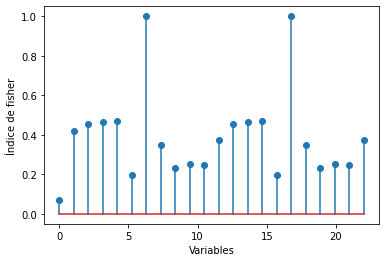

Index(['Opp.OffRebounds', 'OffRebounds', 'Game'], dtype='object')

In [ ]:
df.columns[np.argpartition(fisher_index(x),3)[:3]]

#Seleccion de caracteristicas : Busqueda Secuencial Ascendente 


In [ ]:
def testingSFS(X,Y,num_ft):
  estimator= SVC(kernel="linear", C=1)
  sfs1 = SFS(estimator, 
            k_features=num_ft, 
            forward=True, 
            floating=False, 
            verbose=2,
            scoring='accuracy',
            cv=0)
  sfs1 = sfs1.fit(x, y)
  return sfs1  

In [ ]:
#Aplicando seleccion de caracteristicas
sfs1=testingSFS(x,y,x.shape[1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  1.2min finished

[2021-01-13 21:52:34] Features: 1/22 -- score: 0.6863821138211382[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  1.1min finished

[2021-01-13 21:53:43] Features: 2/22 -- score: 0.8038617886178862[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   53.4s finished

[2021-01-13 21:54:36] Features: 3/22 -- score: 0.8147357723577235[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [ ]:
#Mostrando resultados con cada conjunto
pd.DataFrame.from_dict(sfs1.subsets_)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
feature_idx,"(2,)","(2, 12)","(2, 10, 12)","(2, 10, 12, 20)","(2, 6, 10, 12, 20)","(2, 6, 10, 12, 16, 20)","(2, 3, 6, 10, 12, 16, 20)","(2, 3, 6, 10, 12, 13, 16, 20)","(2, 3, 6, 10, 11, 12, 13, 16, 20)","(2, 3, 6, 10, 11, 12, 13, 16, 20, 21)","(2, 3, 6, 10, 11, 12, 13, 14, 16, 20, 21)","(2, 3, 4, 6, 10, 11, 12, 13, 14, 16, 20, 21)","(2, 3, 4, 6, 10, 11, 12, 13, 14, 16, 19, 20, 21)","(2, 3, 4, 6, 8, 10, 11, 12, 13, 14, 16, 19, 20...","(2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 16, 19,...","(0, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 16, ...","(0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
cv_scores,[0.6863821138211382],[0.8038617886178862],[0.8147357723577235],[0.8369918699186992],[0.8585365853658536],[0.8813008130081301],[0.892479674796748],[0.9032520325203252],[0.9084349593495935],[0.9198170731707317],[0.9231707317073171],[0.9300813008130081],[0.9306910569105691],[0.9302845528455285],[0.9307926829268293],[0.9310975609756098],[0.9301829268292683],[0.9298780487804879],[0.9295731707317073],[0.9289634146341463],[0.9282520325203252],[0.9260162601626016]
avg_score,0.686382,0.803862,0.814736,0.836992,0.858537,0.881301,0.89248,0.903252,0.908435,0.919817,0.923171,0.930081,0.930691,0.930285,0.930793,0.931098,0.930183,0.929878,0.929573,0.928963,0.928252,0.926016
feature_names,"(2,)","(2, 12)","(2, 10, 12)","(2, 10, 12, 20)","(2, 6, 10, 12, 20)","(2, 6, 10, 12, 16, 20)","(2, 3, 6, 10, 12, 16, 20)","(2, 3, 6, 10, 12, 13, 16, 20)","(2, 3, 6, 10, 11, 12, 13, 16, 20)","(2, 3, 6, 10, 11, 12, 13, 16, 20, 21)","(2, 3, 6, 10, 11, 12, 13, 14, 16, 20, 21)","(2, 3, 4, 6, 10, 11, 12, 13, 14, 16, 20, 21)","(2, 3, 4, 6, 10, 11, 12, 13, 14, 16, 19, 20, 21)","(2, 3, 4, 6, 8, 10, 11, 12, 13, 14, 16, 19, 20...","(2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 16, 19,...","(0, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 16, ...","(0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [ ]:
#Showing name of each column
indexSeleccion=[  2, 3, 4, 6, 10, 11, 12, 13, 14, 16, 20, 21]
for i in indexSeleccion:
  print(df.iloc[:,i].name)

Home
FieldGoals.
X3PointShots.
FreeThrows.
OffRebounds
TotalRebounds
Assists
Steals
Turnovers
TotalFouls
Opp.FieldGoals.
Opp.3PointShots.
Opp.FreeThrows.
Opp.TotalRebounds
Opp.Blocks
Opp.Turnovers
Opp.TotalFouls


In [ ]:
#Se cambian los valores de X y Y con las caracteristicas seleccionadas:
indexSeleccion=[  2,3, 4, 6, 10, 11, 12, 13, 14, 16, 20, 21,22]# 22 is the variable to predict
df.columns[indexSeleccion]
dfNew=df[df.columns[indexSeleccion]]

X,Y = getXY(dfNew)

##Probando con los mejores tres modelos

In [ ]:
#Redes neuronales
resultadosMlp = testingMlp(X,Y, [1,2], [5,10],False)
#Maquinas de Soporte Vectorial
resultadosSVC=testingSVC(X,Y,kernels=['linear','rbf'],gammas = [0.001,0.01], params_reg = [0.1,1],extraccion=False)
#Analisis Discriminante Cuadratico
resultadosQDA = testingQDA(X,Y,[0],False)

##Resultados


In [ ]:
resultadosMlp

,# Hidden layers,# Neurons,Accuracy Train,Std Train,Accuracy Test,Std Test
0,1.0,5.0,0.687398,0.002218,0.686382,0.006769
1,1.0,10.0,0.686992,0.001952,0.686789,0.007240
2,1.0,20.0,0.686619,0.002413,0.686687,0.007096
3,1.0,30.0,0.686450,0.002200,0.686585,0.007266
4,2.0,5.0,0.686619,0.002130,0.686992,0.007412
5,2.0,10.0,0.686585,0.002153,0.686992,0.007412
6,2.0,20.0,0.686450,0.002544,0.686382,0.006817
7,2.0,30.0,0.687026,0.002145,0.686280,0.007926
8,3.0,5.0,0.687398,0.001662,0.686484,0.006931
9,3.0,10.0,0.686958,0.002013,0.685772,0.006649


In [ ]:
resultadosSVC

,kernel,gamma,param_reg,Accuracy Train,Std Train,Accuracy Test,Std Test,% de vectores de soporte
0,linear,0.001,0.1,0.686619,0.002130,0.686992,0.007412,70.010163
1,linear,0.001,1.0,0.686619,0.002130,0.686992,0.007412,69.864499
2,linear,0.010,0.1,0.686619,0.002130,0.686992,0.007412,70.010163
3,linear,0.010,1.0,0.686619,0.002130,0.686992,0.007412,69.864499
4,rbf,0.001,0.1,0.687839,0.001920,0.686687,0.005991,95.691057
5,rbf,0.001,1.0,0.687466,0.001937,0.686179,0.007632,76.178862
6,rbf,0.010,0.1,0.687466,0.001937,0.686179,0.007632,76.185637
7,rbf,0.010,1.0,0.686585,0.002153,0.687093,0.007240,70.528455


In [ ]:
resultadosQDA

,Reg param,Accuracy train,Std train,Accuracy test,Std test
0,0.0,0.930183,0.00104,0.928049,0.005826


#Extracion de Caracteristicas con PCA


In [ ]:
#ejercicio de código
def training_PCA(n_comp, X, Y):

    Errores = np.ones(5)
    j = 0
    kf =  StratifiedKFold(n_splits=5)

    varianza_acum=[]

    for train_index, test_index in kf.split(X,Y):  
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # ¿es necesario estandarizacion de datos?
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
 
        #dejar el mismo nombre del objeto 
        pca = PCA(n_components=n_comp)
        # para calcular costo computacional
        
        # es recomendable usar el metodo que ajusta y transforma
        X_train_pca = pca.fit_transform(X= X_train)
        # aca solo usar el metodo de transformar (ya que en el anterior el pca se ajusto)
        X_test_pca = pca.transform(X= X_test)

        varianza_acum.append(sum(pca.explained_variance_ratio_))

    return np.mean(varianza_acum)

In [ ]:
def testing_PCA(n_feats, X, Y):
    df = pd.DataFrame()
    idx = 0

   
    for f in n_feats:
        #Implemetamos la metodología de validación 
        df.loc[idx,'NUM_VAR'] = f
        df.loc[idx,'% VAR ACUM'] = training_PCA(n_comp=f, X=X,Y=Y)
        idx+=1
    return df


In [ ]:
testing_PCA(n_feats=[2,5,10,15,x.shape[1]], X= x, Y = y)

,NUM_VAR,% VAR ACUM
0,2.0,0.232764
1,5.0,0.476395
2,10.0,0.728493
3,15.0,0.905184
4,22.0,1.000000


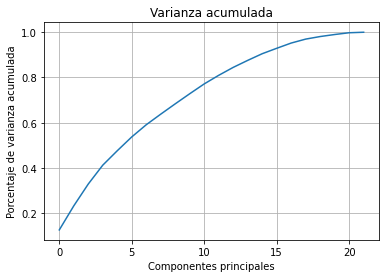

In [ ]:
# aca realizamos una curva de varianza explicada del PCA
pca_varianza = PCA(n_components=x.shape[1]).fit(StandardScaler().fit_transform(x))
plt.plot(np.cumsum(pca_varianza.explained_variance_/np.sum(pca_varianza.explained_variance_)))
plt.title('Varianza acumulada')
plt.xlabel('Componentes principales')
plt.ylabel('Porcentaje de varianza acumulada')
plt.grid()

##Probando con los tres mejores modelos


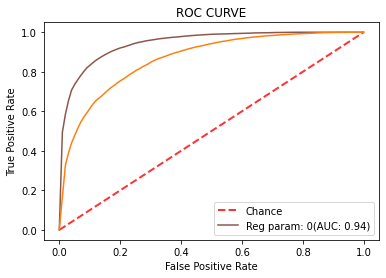

In [ ]:
#Analisis Discriminante Cuadratico
resultadosQDA = testingQDA(x,y,[0,1],True)
#resultadosMlp = testingMlp(x,y, [1], [5,10],True)
#resultadosSVC=testingSVC(x,y,kernels=['linear','rbf'],gammas = [0.001,0.01], params_reg = [0.1,1],extraccion=True)

In [ ]:
resultadosQDA

,Reg param,Accuracy train,Std train,Accuracy test,Std test
0,0.0,0.868775,0.001834,0.862805,0.00956
1,1.0,0.822891,0.045944,0.819258,0.04529


In [ ]:
resultadosMlp

,# Hidden layers,# Neurons,Accuracy Train,Std Train,Accuracy Test,Std Test
0,1.0,5.0,0.913753,0.001941,0.911992,0.006979
1,1.0,10.0,0.913415,0.002208,0.912297,0.006688


In [ ]:
resultadosSVC.sort_values(by=['Accuracy Test','Std Test'],ascending=False)


,kernel,gamma,param_reg,Accuracy Train,Std Train,Accuracy Test,Std Test,% de vectores de soporte
0,linear,0.001,0.1,0.913449,0.002336,0.912907,0.006398,22.713415
2,linear,0.010,0.1,0.913449,0.002336,0.912907,0.006398,22.713415
3,linear,0.010,1.0,0.913889,0.002472,0.912398,0.006558,21.825881
1,linear,0.001,1.0,0.913821,0.002401,0.912297,0.006614,21.832656
5,rbf,0.001,1.0,0.911755,0.002143,0.910569,0.007777,40.020325
7,rbf,0.010,1.0,0.915007,0.001908,0.909451,0.006632,27.120596
6,rbf,0.010,0.1,0.912398,0.001784,0.909248,0.007536,43.539973
4,rbf,0.001,0.1,0.899560,0.001060,0.897154,0.009279,73.424797
